# Index Optimizer

## Data

### Index selection for trading universe

In this execise, SP 500 is selected as the benchmark index. A list of component stocks was pulled from ***https://www.slickcharts.com/sp500*** as starting point of building the trading universe. 

Tickers information is saved under
```bash
./data/tickers.csv
```



### stock price data

Stock price data is pulled from yahoo finance with ```yfinance``` package.
* source: yahoo finance
* time horizon: 2020-01-01 to 2023-08-09
* frequence: daily
* fields: [Adj Close]

In [7]:
import yfinance as yf
import pandas as pd

ticker_path = './data/tickers.csv'
tickers = pd.read_csv(ticker_path, header=None).values.ravel().tolist()

start_date = '2023-01-01'
end_date = '2023-08-09'
raw = yf.download(tickers, period='1d', start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  504 of 504 completed


In [12]:
raw['CARR']

Date
2023-01-03    41.263741
2023-01-04    41.680241
2023-01-05    41.184402
2023-01-06    42.771091
2023-01-09    43.138012
                ...    
2023-08-02    58.980000
2023-08-03    58.099998
2023-08-04    57.080002
2023-08-07    58.099998
2023-08-08    57.389999
Name: CARR, Length: 150, dtype: float64

In [9]:
raw.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,149.510452,12.74,149.137817,124.538658,157.637115,162.890045,108.025566,62.459999,267.136719,336.920013,...,85.415924,68.939453,104.787399,32.453468,110.050858,125.791306,126.826683,260.200012,47.253483,145.870972
2023-01-04,151.134720,13.59,149.482269,125.823189,158.908859,161.482132,109.632431,62.770000,266.227295,341.410004,...,90.693939,69.529770,105.092384,33.535580,109.881943,127.495468,128.002487,262.989990,48.979412,147.966934
2023-01-05,151.573166,13.99,150.732147,124.488876,158.714691,161.690353,109.228249,62.939999,259.940826,328.440002,...,91.132935,68.122841,107.443733,32.850574,106.762039,126.524490,125.630959,260.059998,48.121323,144.480286
2023-01-06,147.148834,14.18,151.578506,129.069336,161.685303,164.297943,110.736549,63.900002,266.098816,332.750000,...,93.357880,70.139771,108.742371,33.188118,110.557587,129.090637,125.252296,273.420013,49.983768,146.655731
2023-01-09,146.949524,14.61,149.846390,129.597076,156.938141,163.564255,110.559105,62.669998,270.586334,341.980011,...,94.116158,70.818634,106.715698,32.751301,111.074257,128.565536,125.601059,279.290009,49.749744,146.079575


Some tickers does not have valid prices data during this period due to various reasons. 

For example, Laboratory Corporation of America Holdings (NYSE: LH) has announced a spin-off of Fortrea Holdings Inc. listing on Nasdaq Global Select Market with a record date of June 20, 2023. Shareholders of LH will receive one (1) share of Fortrea Holdings Inc (FTRE) for each share of LH held on the record date. The shares of FTRE will be distributed to LH shareholders on the payment date of June 30, 2023. The first day of “regular way” trading is anticipated to be July 3, 2023.

For the sake of index optimizer demonstration, those tickers without valid price data for the full history was removed.

In [20]:
to_exclude = set(col for col in tickers if raw[col].isnull().sum() != 0)
df_px =  raw[[ticker for ticker in tickers if ticker not in to_exclude]] 
df_px.to_csv('./data/px.csv')

Zip the file to save space.

In [16]:
!zip ./data/px.csv.zip ./data/px.csv

  adding: data/px.csv.new (deflated 65%)


## Build the optimizer

Portfolio optimization under Markowitz framework is a quadratic programming problem.


Consider the following quadratic programming problem:


Minimize:
\begin{align*}
    & \frac{1}{2} \mathbf{x}^T \mathbf{Q} \mathbf{x} + \mathbf{c}^T \mathbf{x}
\end{align*}

Subject to:
\begin{align*}
    & \mathbf{A}_{eq} \mathbf{x} = \mathbf{b}_{eq} \quad \text{(Equality Constraints)} \\
    & \mathbf{Q}_{ineq} \mathbf{x} \leq \mathbf{h}_{ineq} \quad \text{(Inequality Constraints)}
\end{align*}

Where:
\begin{align*}
    & \mathbf{x} = [x_1, x_2, \ldots, x_n]^T \quad \text{(Vector of new positions to find)} \\
    & \mathbf{Q} \quad \text{(Positive semi-definite quadratic coefficient matrix)} \\
    & \mathbf{c} = [c_1, c_2, \ldots, c_n]^T \quad \text{(Signal vector for each stock)} \\
    & \mathbf{A}_{eq} \quad \text{(Matrix of equality constraint coefficients)} \\
    & \mathbf{b}_{eq} = [b_{eq_1}, b_{eq_2}, \ldots, b_{eq_m}]^T \quad \text{(Vector of equality constraint constants)} \\
    & \mathbf{Q}_{ineq} \quad \text{(Matrix of inequality constraint coefficients)} \\
    & \mathbf{h}_{ineq} = [b_{ineq_1}, b_{ineq_2}, \ldots, b_{ineq_p}]^T \quad \text{(Vector of inequality constraint constants)}
\end{align*}

In this exercise, we have the following assumptions for the portfolio:
* Capital is fully invested.
* Long only.
* Rebalance at end of day.
* No extra capital in flow.
* No transaction cost.

And the following requirements:
* Each components weight should deviate from index weight less than 3%.
* Turnover weight should be less than 15%.


With these assumptions and requirements in mind, we augment this problem with n variable, to 3n variable with stock traded when rebalancing, namely include $x_{buy}$ and $x_{sell}$ for each stock in the optimization.

Minimize:
\begin{align*}
    & \frac{1}{2} \mathbf{x}^T \mathbf{Q} \mathbf{x} + \mathbf{c}^T \mathbf{x}
\end{align*}

Subject to:
\begin{align*}
    & \sum_{i=1}^{N} x_i = 1 \\
    & x_i = x_{0,i} + x_i^+ - x_i^-, i \in [1, N] \\
    & \sum_{i=1}^N x_i^+ + \sum_{i=1}^N x_i^- \le \tau \\
    & \mathbf{lb} <= x_i <= \mathbf{ub}, i \in [1, N] \\
    & 0 <= x_i^+ <=1, i \in [1, N] \\
    & 0 <= x_i^- <=1, i \in [1, N] \\
\end{align*}

Where:
\begin{align*}
    & \mathbf{lb} \quad \text{ is the lower bound of } x \text{, allowing up to a 3\% deviation from the index} \\
    & \mathbf{ub} \quad \text{ is the upper bound of } x \text{, allowing up to a 3\% deviation from the index} \\
    & \mathbf{Q} \quad \text{Positive semi-definite quadratic coefficient matrix} \\
    & \mathbf{c} = [c_1, c_2, \ldots, c_n]^T \quad \text{Signal vector for each stock} \\
    & \mathbf{x}_i^+ \quad \text{notional of buy orders on rebalance} \\
    & \mathbf{x}_i^- \quad \text{notional of sell orders on rebalance} \\
    & \mathbf{\tau} \quad \text{maximum turnover} \\
\end{align*}

There will be five constraints in total:
* ConstraintInterface
* FullyInvestConstraint
* AccountingConstraint
* TurnoverConstraint
* IndexDeviateConstraint
* TradeNotionalConstraint

For details of the implementation, we can refer to the code. 

## Backtesting

In [1]:
from opt.optimizer import Optimizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# loading in data
df = pd.read_csv('/home/yifan/ws/mlp-task/index-optimizer/data/px.csv.zip', compression='zip', parse_dates=['Date']).set_index('Date')

In [3]:
# calculate covariance
# dfr is the daily simple returns
dfr = (df.diff().shift(-1) / df).dropna()
dfr.index = df.index[1:]

# use data from 2020-01-02 to 2021-12-31 as training data to calibrate the covariance
cov = dfr.query('Date < 20230101').cov().values

In [4]:
# check cov
assert np.isnan(cov).sum() == 0

In [5]:
cov

array([[0.00054121, 0.00041327, 0.00038017, ..., 0.0004737 , 0.00025551,
        0.00026916],
       [0.00041327, 0.00047917, 0.00037822, ..., 0.00044884, 0.00025092,
        0.00026   ],
       [0.00038017, 0.00037822, 0.00060635, ..., 0.0003125 , 0.00018493,
        0.00022649],
       ...,
       [0.0004737 , 0.00044884, 0.0003125 , ..., 0.00182106, 0.00073076,
        0.00061289],
       [0.00025551, 0.00025092, 0.00018493, ..., 0.00073076, 0.00077689,
        0.00038263],
       [0.00026916, 0.00026   , 0.00022649, ..., 0.00061289, 0.00038263,
        0.00061508]])

We are going to run the backtest on dataset from 20230101 to 20230809

In [6]:
tickers = df.columns.tolist()

In [7]:
df_px = df.query('Date >= 20221230')

px = df_px.values

px.shape

(151, 498)

Assumption:
* No rebalance of index during this period from 20230103 to 20230808.

We build our portfolio using prices on EOD of 20221230, and start to rebalance our portfolio on 20230103. The reference index will be an initailly equally weighted portfolio.

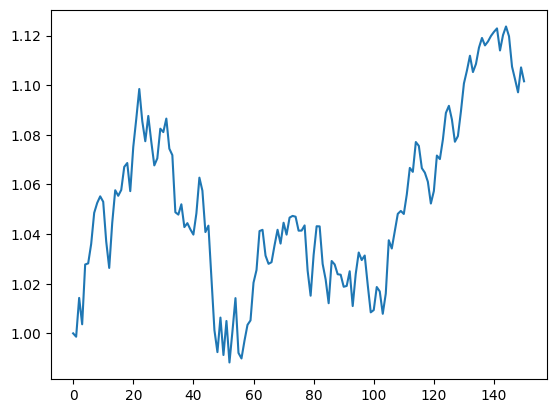

In [8]:
n = len(df_px.columns)
idx = (np.ones(n) / n / px[0]) * px 

plt.plot(np.sum(idx, axis=1));

In [9]:
from opt.constraints import AccountingConstraint
from opt.constraints import FullyInvestConstraint
from opt.constraints import TradeNotionalConstraint
from opt.constraints import TurnoverConstraint
from opt.constraints import IndexDeviateConstraint
from opt.optimizer import Optimizer

In [10]:
# use sod, eod to hold

np.random.seed(0)

N = px.shape[0] - 1
n = px.shape[1]

sod = np.zeros((N, n))
eod = np.zeros((N, n))
pnl = np.zeros((N, n))
ret = dfr.values[-N:, :]

In [11]:
turnover_limit = 0.15
idx_dev = 0.03

In [12]:
optimizer = Optimizer(tickers, cov)

In [13]:
o = optimizer

In [25]:
signal_std = 0.01

x0 = np.copy(idx[0, :])
# assume we have crystal ball
signal = np.random.randn(n) * signal_std


constraints = [
    FullyInvestConstraint(tickers),
    AccountingConstraint(tickers, x0),
    TradeNotionalConstraint(tickers),
    TurnoverConstraint(tickers, turnover_limit),
    IndexDeviateConstraint(tickers, idx[0, :], idx_dev),
]

optimizer.reset()

res = optimizer.update_x0(x0).update_signal(signal).add_constraints(constraints).solve()

# for i, date in enumerate(pd.date_range('20230103', '20230808')[:2]):
#     eod_i = sod[i, :] * (1 + ret[i, :])

#     # liquidate and realize any pnl
#     pnl_i = eod_i - idx[i+1, :]

    
#     turnover_quota_left = turnover_limit - 
#     print(date)